In this notebook, we'll customize our own dataset based on TorchDrug lib.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils import data as torch_data
from torchdrug import data, datasets, utils, transforms
from torchdrug.core import Registry as R
%matplotlib inline

In [2]:
df = pd.read_csv("/home/tangwuguo/datasets/scope40/pdb_scope_db40.csv")
class_label = df['label']

In [3]:
class_label.unique().size

2065

# 1.Customize Scope Dataset

In [4]:
class ScopeSuperFamilyClassify(data.ProteinDataset):
    source_file = "pdb_scope_db40.csv"
    pdb_dir = "dbstyle_all-40-2.08"
    processed_file = 'scope_superfamily.pkl.gz'

    label2id_dir = 'pdb_scope_label2id.pkl'
    id2label_dir = 'pdb_scope_id2label.pkl'
    
    splits = ["train", "valid", "test"]
    split_ratio = [0.8, 0.1]
    target_fields = ["superfamily_label"]  # label column

    def __init__(self, path='/home/tangwuguo/datasets/scope40', verbose=1, **kwargs):
        if not os.path.exists(path):
            raise FileExistsError("Unknown path `%s` for SCOPE dataset" % path)
        self.path = path            
        df = pd.read_csv(os.path.join(path, self.source_file))
        pkl_file = os.path.join(path, self.processed_file)
        
        if os.path.exists(pkl_file):  
            # load processed pkl
            self.load_pickle(pkl_file, verbose=verbose, **kwargs)
        else:            
            pdb_files = df['id']
            pdb_files = pdb_files.apply(lambda x: os.path.join(path, self.pdb_dir, x+'.ent')).tolist()
            self.load_pdbs(pdb_files=pdb_files, verbose=1)
            self.save_pickle(pkl_file, verbose=verbose)
                    
        len = df['id'].size
        train_size = int(len*self.split_ratio[0])
        valid_size = int(len*self.split_ratio[1])
        test_size = len - train_size - valid_size
        self.num_samples = [train_size, valid_size, test_size]
        self.targets = {'superfamily_label': torch.tensor(df['label'].tolist())}
    
    
    def split(self, keys=None):
        keys = keys or self.splits
        offset = 0
        splits = []
        for split_name, num_sample in zip(self.splits, self.num_samples):
            if split_name in keys:
                split = torch_data.Subset(self, range(offset, offset + num_sample))
                splits.append(split)
            offset += num_sample
        return splits
        
    
    def get_item(self, index):
        if self.lazy:
            protein = self.load_hdf5(self.pdb_files[index])
        else:
            protein = self.data[index].clone()
        if hasattr(protein, "residue_feature"):
            with protein.residue():
                protein.residue_feature = protein.residue_feature.to_dense()
        item = {"graph": protein, "superfamily_label": self.targets["superfamily_label"][index]}
        if self.transform:
            item = self.transform(item)
        return item

In [5]:
import time

truncate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view="residue")
transform = transforms.Compose([truncate_transform, protein_view_transform])

start_time = time.time()
dataset = ScopeSuperFamilyClassify("/home/tangwuguo/datasets/scope40", transform=transform)
end_time = time.time()
print("Duration of second instantiation: ", end_time - start_time)


Loading /home/tangwuguo/datasets/scope40/scope_superfamily.pkl.gz: 100%|████████████████████████████████████████████████████████████████████████████| 14883/14883 [01:42<00:00, 144.97it/s]

Duration of second instantiation:  102.68638348579407


In [6]:
dataset[0]["superfamily_label"]

tensor(1797)

In [7]:
train_set, valid_set, test_set = dataset.split()
print("Shape of function labels for a protein: ", dataset[0]["superfamily_label"].shape)
print("train samples: %d, valid samples: %d, test samples: %d" % (len(train_set), len(valid_set), len(test_set)))

Shape of function labels for a protein:  torch.Size([])
train samples: 12140, valid samples: 1517, test samples: 1519


In [8]:
train_set[0]

{'graph': Protein(num_atom=2559, num_bond=5232, num_residue=327),
 'superfamily_label': tensor(1797)}

# 2.Dynamic Graph Cosntruct

/homeb/tangwuguo/miniconda3/envs/cbc23/lib/python3.8/site-packages/torchdrug/data/molecule.py:586: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


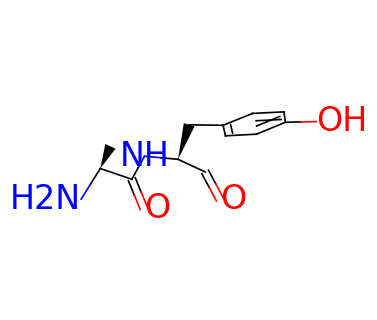

In [9]:
from torchdrug import data

protein = dataset[0]["graph"]
is_first_two = (protein.residue_number == 4) | (protein.residue_number == 5)
first_two = protein.residue_mask(is_first_two, compact=True)
first_two.visualize()

In [10]:
protein.residue_number

tensor([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 1

In [11]:
from torchdrug import layers
from torchdrug.layers import geometry

In [12]:
graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()], 
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

_protein = data.Protein.pack([protein])
protein_ = graph_construction_model(_protein)
print("Graph before: ", _protein)
print("Graph after: ", protein_)

degree = protein_.degree_in + protein_.degree_out
print("Average degree: ", degree.mean())
print("Maximum degree: ", degree.max())
print("Minimum degree: ", degree.min())
print("Number of zero-degree nodes: ", (degree == 0).sum())

Graph before:  PackedProtein(batch_size=1, num_atoms=[2559], num_bonds=[5232], num_residues=[327])
Graph after:  PackedProtein(batch_size=1, num_atoms=[327], num_bonds=[6657], num_residues=[327])
Average degree:  tensor(40.7156)
Maximum degree:  tensor(79.)
Minimum degree:  tensor(12.)
Number of zero-degree nodes:  tensor(0)


In [13]:
print(protein_.atom_feature.shape)
print(protein_.residue_feature.shape)
print(protein_.edge_feature.shape)
print(protein_.num_node)
print(protein_.num_relation)
print(protein_.adjacency)
print(protein_)

torch.Size([327, 66])
torch.Size([327, 21])
torch.Size([6657, 59])
tensor(327)
tensor(7)
tensor(indices=tensor([[232, 230, 163,  ..., 216, 217, 215],
                       [193, 195, 194,  ..., 210, 210, 210],
                       [  1,   1,   1,  ...,   0,   0,   0]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(327, 327, 7), nnz=6657, layout=torch.sparse_coo)
PackedProtein(batch_size=1, num_atoms=[327], num_bonds=[6657], num_residues=[327])


# 3.GearNet

In [14]:
from torchdrug import models
from torchdrug import tasks

In [15]:
gearnet = models.GearNet(input_dim=21, hidden_dims=[512, 512, 512], num_relation=7,
                         batch_norm=True, concat_hidden=True, short_cut=True, readout="sum")

gearnet_edge = models.GearNet(input_dim=21, hidden_dims=[512, 512, 512], 
                              num_relation=7, edge_input_dim=59, num_angle_bin=8,
                              batch_norm=True, concat_hidden=True, short_cut=True, readout="sum")

In [16]:
graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()],
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

task = tasks.PropertyPrediction(gearnet, graph_construction_model=graph_construction_model, num_mlp_layer=3, 
                                          task=dataset.tasks, num_class=2065, criterion="ce", metric=["auprc", "auroc"], verbose=1)

In [17]:
dataset.tasks

['superfamily_label']

In [18]:
from torchdrug import core

optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[1], batch_size=64)
solver.train(num_epoch=1)
solver.evaluate("valid")
# solver.evaluate("test")

14:39:27   Preprocess training set
14:40:28   {'batch_size': 64,
 'class': 'core.Engine',
 'gpus': [1],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'class': 'optim.Adam',
               'eps': 1e-08,
               'lr': 0.0001,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'ce',
          'graph_construction_model': {'class': 'layers.GraphConstruction',
                                       'edge_feature': 'gearnet',
                                       'edge_layers': [SpatialEdge(),
                                                       KNNEdge(),
                                                       SequentialEdge()],
                                       'node_layers': [AlphaCarbonNode()]},
          'metric': ['auprc', 'auroc'],
          'model': {'activation': 'relu',
 

{'auprc [superfamily_label]': tensor(1000.2250, device='cuda:1'),
 'auroc [superfamily_label]': tensor(0., device='cuda:1')}